# chord progressions KMeans

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt 
import math
from ipynb.fs.full.Utils import createKDeplot, loadDataFrames
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from ipynb.fs.full.Pipeline import removeConstantFeatures, applyBoxCoxAllFeatures, centerAndScale, applyEuclideanDistance, getIndexAndVector
import dask_ml.cluster
import plotly.express as px
import os

In [2]:
transitionMatrices = pd.read_csv('./data/unified/transitionMatrices.csv')
transitionMatrices = transitionMatrices.iloc[:, 1:]

transitionMatrices = transitionMatrices.sort_values('id')
transitionMatrices.id = transitionMatrices.id.astype('int64')
transitionMatrices = transitionMatrices.set_index('id')
    

In [3]:
transitionMatrices.describe()

,0,1,2,3,4,5,6,7,8,9,...,1284,1286,1287,1288,1290,1291,1292,1293,1294,1295
count,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,...,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5.980000e+03,5980.000000,5980.000000,5980.000000,5980.000000
mean,0.024322,0.000767,0.000118,0.000168,0.000075,0.002616,0.007883,0.002295,0.000074,0.000230,...,0.000008,0.000041,0.000274,0.000124,0.000047,5.929932e-07,0.000400,0.000031,0.000023,0.000038
std,0.060962,0.008348,0.002821,0.003465,0.001520,0.016245,0.029557,0.014214,0.001928,0.003065,...,0.000311,0.000966,0.003717,0.002320,0.001718,4.585644e-05,0.004026,0.000903,0.001763,0.000861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,0.842105,0.350000,0.148936,0.210526,0.062500,0.428571,0.355263,0.380952,0.100000,0.123457,...,0.016667,0.048780,0.156550,0.100000,0.120690,3.546099e-03,0.150000,0.043478,0.136364,0.038462


In [4]:
transitionMatrices.sum(axis = 1).sum(axis=0)

5979.999999999996

In [5]:
df = transitionMatrices

In [6]:
df = removeConstantFeatures(df)
df = applyBoxCoxAllFeatures(df)
# df = centerAndScale(df)

In [7]:
X = df.values.tolist()

In [8]:
numClusters = 3

km = dask_ml.cluster.KMeans(n_clusters=numClusters)
km.fit(X)

KMeans(n_clusters=3)

In [9]:
## Concatenating the labels into the dataset 
labels = list(km.labels_.compute())
df['category'] = labels

In [10]:
fig = px.histogram(df, x="category", title='Chord Progressions / Clusters')
fig.show()

### Elbow criterion method

Plots the number of clusters against within-cluster-sum-of-squared-errors (SSE) sum of squared distances from every data point to their cluster center

In [11]:
from sklearn.cluster import KMeans

import seaborn as sns
from matplotlib import pyplot as plt
sse = {}
for k in range(1,12):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_

In [12]:
sse

{1: 30.021703093551565,
 2: 21.270725376994495,
 3: 18.198243582333834,
 4: 16.072778951032287,
 5: 14.769741689898355,
 6: 13.621292693164689,
 7: 13.046654172383718,
 8: 12.583261533706624,
 9: 12.177396324074758,
 10: 11.751541342770556,
 11: 11.373149768873686}

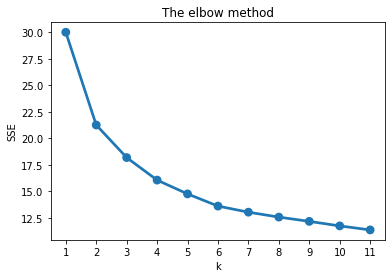

In [13]:
plt.title('The elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1290,1291,1292,1293,1294,1295,category
id,,,,,,,,,,,,,,,,,,,,,
23,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
105,0.02919,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1
118,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.008545,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
120,0.01840,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
292,0.01100,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.002244,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002496,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2
6002497,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
6002498,0.00000,0.000737,0.0,0.000162,0.0,0.002546,0.008343,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0


In [15]:
originalSongId = 180849 # The Scientist Original
originalSongCategory = df.loc[[originalSongId]].category.values[0]
filteredData = df[df.category == originalSongCategory]
ids = filteredData.index
originalSongVector = filteredData.loc[originalSongId]

In [16]:
os.makedirs('./data', exist_ok=True)  
df.to_csv('./data/unified/07-transitionsClustered.csv')

In [17]:
filteredData.loc[filteredData.index > 5000000]

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1290,1291,1292,1293,1294,1295,category
id,,,,,,,,,,,,,,,,,,,,,
5000011,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5000020,0.000000,0.0,0.0,0.0,0.0,0.000000,0.008591,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6000006,0.022577,0.0,0.0,0.0,0.0,0.002552,0.008596,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6000020,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6000021,0.000000,0.0,0.0,0.0,0.0,0.000000,0.008594,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002488,0.000000,0.0,0.0,0.0,0.0,0.000000,0.008595,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6002490,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6002491,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [18]:
## Silhouette

In [19]:
from sklearn import datasets
from sklearn.cluster import KMeans
from  sklearn.metrics import silhouette_score

# Instantiate the KMeans models

km = KMeans(n_clusters=2, random_state=42)

# Fit the KMeans model

km.fit_predict(df)

# Calculate Silhoutte Score

score = silhouette_score(df, km.labels_, metric='euclidean')

# Print the score

print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.780


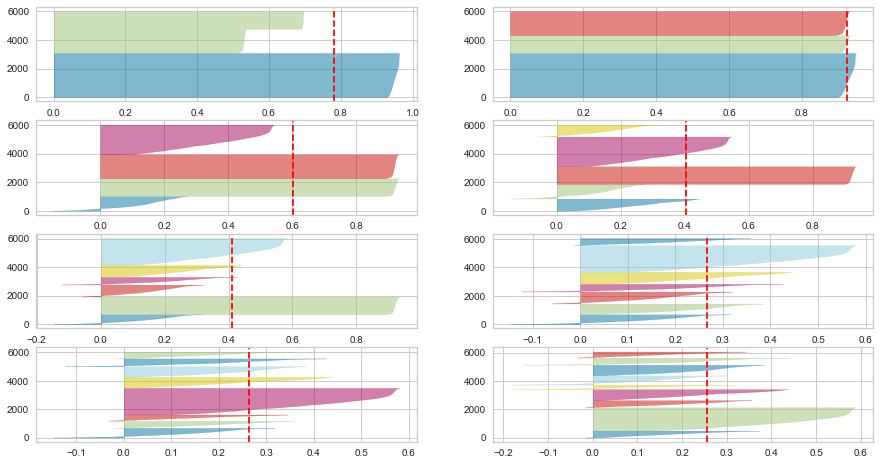

In [20]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)